# Step 1: Import Libraries and Set Up Environment

In [43]:
# Step 1: Import Libraries and Set Up Environment
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import warnings

# Suppress warnings and set up visualization styles

In [44]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='viridis')


In [45]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


# Step 2: Define Constants and Load Data Paths

In [46]:
# Define Constants and Load Data Paths
DATA_FOLDER = r"../dataset"  # Replace with your data folder path
TRAIN_FILE = "train-00000-of-00001-c08a401c53fe5312.parquet"
TEST_FILE = "test-00000-of-00001-44110b9df98c5585.parquet"

DIAGNOSIS_LABELS = {
    0: "Healthy",
    1: "Mild Cognitive Impairment",
    2: "Alzheimer's Disease",
    3: "Other Neurological Condition"
}

In [47]:
# Construct file paths for train and test datasets
train_file_path = os.path.join(DATA_FOLDER, TRAIN_FILE).replace("\\", "/")
test_file_path = os.path.join(DATA_FOLDER, TEST_FILE).replace("\\", "/")

In [48]:
# Load the training and testing datasets (use small samples for demonstration)
train_data = pd.read_parquet(train_file_path).head(100)  # Load first 100 rows for training
test_data = pd.read_parquet(test_file_path).head(50)     # Load first 50 rows for testing

print("Training and testing data loaded successfully.")

Training and testing data loaded successfully.


# Step 3: Define Image Decoding Function


In [49]:
def decode_image_from_bytes(image_dict):
    """
    Decodes image bytes into a NumPy array.
    """
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)  # Decode as a color image (BGR format)
        return img
    return None

print("Image decoding function defined.")

Image decoding function defined.


# Step 4: Apply Decoding to Train and Test DataFrames

In [50]:
train_data['decoded_scan'] = train_data['image'].apply(decode_image_from_bytes)
test_data['decoded_scan'] = test_data['image'].apply(decode_image_from_bytes)

print("Images decoded successfully.")

Images decoded successfully.


# Step 5: Display Sample Data and Label Distribution

In [51]:
train_data.head()



,image,label,decoded_scan
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [52]:
test_data.head()

,image,label,decoded_scan
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


### 5.1  Plot label distribution in the training dataset

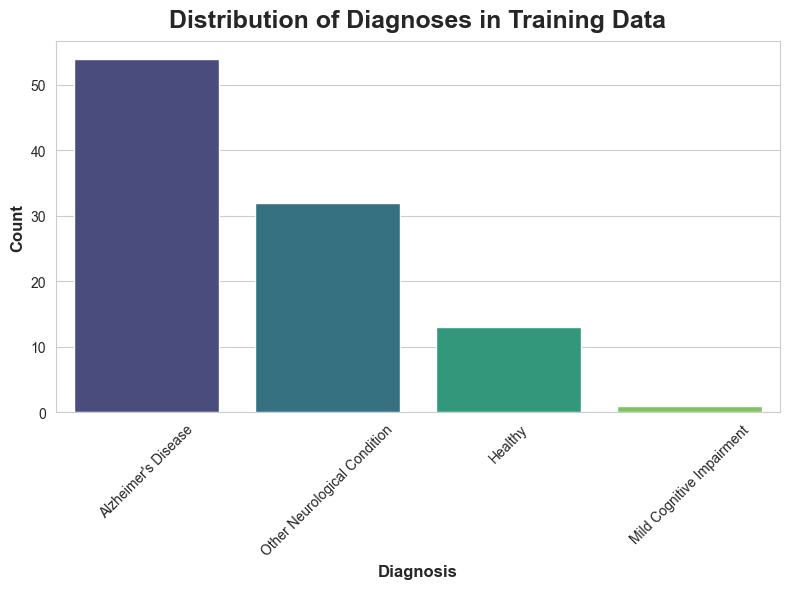

In [53]:
label_distribution = train_data['label'].map(DIAGNOSIS_LABELS ).value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette="viridis")
plt.title("Distribution of Diagnoses in Training Data")
plt.ylabel("Count")
plt.xlabel("Diagnosis")
plt.xticks(rotation=45)
plt.show()


# Step 6: Preprocess Images for Model Input (Resizing and Normalization)


In [54]:

def preprocess_images(image_array):
    """
    Resize images to (128x128) and normalize pixel values.
    """
    resized_images = []
    for img in image_array:
        if img is not None:
            resized_img = cv2.resize(img, (128, 128)) / 255.0  # Normalize pixel values to [0,1]
            resized_images.append(resized_img)
        else:
            resized_images.append(np.zeros((128, 128, 3)))  # Placeholder for missing images
    return np.array(resized_images)

X_train_images = preprocess_images(train_data['decoded_scan'])
X_test_images = preprocess_images(test_data['decoded_scan'])

y_train_labels = train_data['label'].values
y_test_labels = test_data['label'].values

print(f"Training images shape: {X_train_images.shape}")
print(f"Testing images shape: {X_test_images.shape}")

Training images shape: (100, 128, 128, 3)
Testing images shape: (50, 128, 128, 3)


# Step 7: Split Training Data into Train/Validation Sets

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train_labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 80
Validation set size: 20


# Step 8: Build the CNN Model for Classification

In [56]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(DIAGNOSIS_LABELS), activation='softmax')  # Output layer with softmax activation
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,116 (14.14 MB)

 Trainable params: 3,706,116 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

# Step 9: Train the Model on Training Data

In [57]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    verbose=1
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.3863 - loss: 2.0775 - val_accuracy: 0.5500 - val_loss: 1.1313
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5403 - loss: 1.1723 - val_accuracy: 0.5500 - val_loss: 1.0059
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5585 - loss: 0.9549 - val_accuracy: 0.5500 - val_loss: 1.0288
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5663 - loss: 0.9652 - val_accuracy: 0.5500 - val_loss: 1.0295
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5998 - loss: 0.9076 - val_accuracy: 0.5500 - val_loss: 1.0703
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6715 - loss: 0.8290 - val_accuracy: 0.5500 - val_loss: 1.0486
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7023 - loss: 0.7977 - val_accuracy: 0.5500 - val_loss: 1.1393
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8125 - loss: 0.5578 - val_accuracy: 0.5500 - val_loss: 1.13

# Step 10: Evaluate the Model on Test Data

In [58]:
test_loss, test_accuracy = model.evaluate(X_test_images, y_test_labels)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4896 - loss: 1.1056

Test Accuracy: 0.5000


# Step 11: Visualize Training History (Loss and Accuracy)

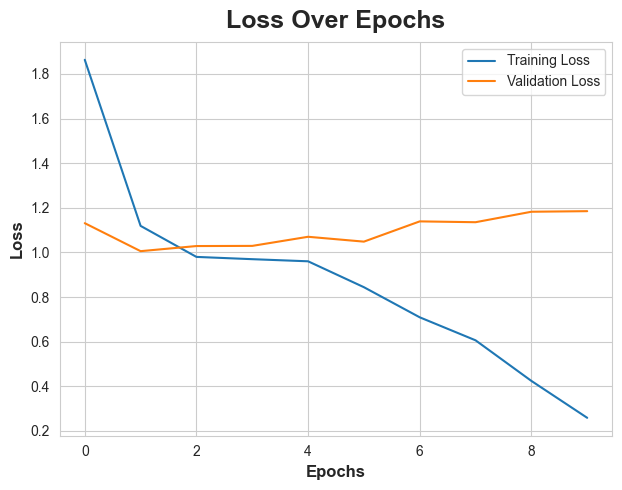

In [59]:
plt.figure(figsize=(12, 5))

# Plot training/validation loss over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


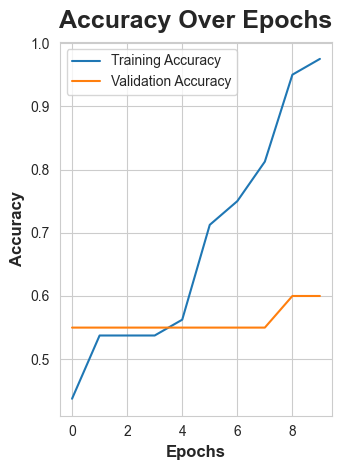

In [60]:
# Plot training/validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()